In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy
import pickle
import utils

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

In [2]:
FURNITURES = ['bed', 'bench', 'chair', 'table']
LAYERS = {'pool1': 0, 'pool2': 1, 'pool3': 2, 'pool4': 3,
          'pool5': 4, 'fc6': 5, 'fc7': 6} # 'prob': 7} taking out probability layer for now. 
FURNITURES_label = ['bedChair_1', 'bedChair_100', 'tableBench_1', 'tableBench_100']

LAYERS_NM = ['pixel', 'pool1', 'pool2', 'pool3', 'pool4', 'pool5', 'fc6', 'fc7']
VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3

NUM_VIEWS = 40
NUM_VIEWS_S = 20

In [3]:
# downloading sketch info (SF takes a while) 
SF = pickle.load(open('/tigress/rslee/SF.p', 'rb'))
S = pickle.load(open('/tigress/rslee/S.p', 'rb'))

In [4]:
# downloading model info 


MF = pickle.load(open('/tigress/rslee/MF.p', 'rb'))
M = pickle.load(open('/tigress/rslee/M.p', 'rb'))

In [5]:
print 'Number of sketches: ' + str(len(S.path))
print 'Number of subjects: ' + str(len(np.unique(S.subj)))


print 'Number of models: ' + str(len(M.path))
num_models = len(M.path)
num_sketches = len(S.path)

Number of sketches: 1400
Number of subjects: 35
Number of models: 320


In [6]:
def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

path_to_sketches = '/home/rslee/sketch_data'

def get_trial_ID_from_metadata(path):
    metadata = pd.read_csv(path)[['wID', 'trial','target']]
    trialID = ["%s_trial_%s_%s" % (metadata['wID'].values[row], metadata['trial'].values[row], metadata['target'].values[row])
               for row in xrange(0,len(metadata))]
    return trialID

def get_viewpoint_from_metadata(path):
    return pd.read_csv(path).viewpoint.values.tolist()

metadata_paths = list_files(path_to_sketches, ext='csv') 
trialID_metadata = sum(map(get_trial_ID_from_metadata, metadata_paths), [])
viewpoint_sketches = np.asarray(sum(map(get_viewpoint_from_metadata, metadata_paths),[]))

print 'Number of metadata files: ' + str(len(metadata_paths))
print 'Number of metadata trials for models: ' + str(len(viewpoint_sketches))


Number of metadata files: 35
Number of metadata trials for models: 1400


In [7]:
# getting the metadata to be sorted correctly. 

inds_metadata = np.argsort(trialID_metadata)
_trialID_metadata = np.asarray(trialID_metadata)[inds_metadata]
_SVP_bt = np.asarray(viewpoint_sketches)[inds_metadata]


In [8]:
SL = np.array(S.label)
# normalize and get means of feature vectors

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):
    # load in and normalize features 
    X = normalize(X)
    _mu = np.zeros((len(np.unique(np.asarray(labels))), X.shape[1]), float)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:

            _mu[vi] = Xv.mean(0)
    return _mu


def get_means_across_views(X, labels, viewpoints): 
    _mu = np.zeros((len(np.unique(viewpoints)) * len(FURNITURES), X.shape[1]),float) # saving the averaged SF per laer here 
    for obj_i, obj in enumerate(FURNITURES):
        inds_object = np.where(labels == obj)
        X_obj = X[inds_object] # taking all the views per object here 
        
        means = get_class_means(X_obj, viewpoints[inds_object])
        
        _mu[obj_i * len(np.unique(viewpoints)): (obj_i + 1) * len(np.unique(viewpoints)), :] = means
    return _mu
        
_SF_bt = []
for layer in xrange(0,7):
    inds = np.argsort(S.trialID.values)
    SF_i = SF[layer]
    _SF_bt.append(SF_i[inds])
_SL_bt = SL[inds]



In [11]:
# getting pixel level data 

SP = np.empty((num_sketches, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), float)
SP_i = 0 # used for the batch index 
for path in S.path: 
    img = utils.load_image(path)
    # take out the fourth dimension, alpha, which controls transparency
    img = img[:,:,:3]

    img = np.asarray(img.flatten()).reshape(1, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z)
          
    SP[SP_i, :] = img
    SP_i += 1 

inds = np.argsort(S.trialID.values)
_SP_bt = SP[inds]

MP = np.empty((num_models, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), float)
MP_i = 0 # used for the batch index 
for path in M.path: 
    img = utils.load_image(path)
    img = np.asarray(img.flatten()).reshape(1, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z)
        
    MP[MP_i, :] = img
    MP_i += 1 
        


In [12]:
# setting the index right for the sketches


inds_final = np.lexsort((_SVP_bt.astype(int), np.asarray(_SL_bt)))
_SVP = _SVP_bt[inds_final]
_SL = _SL_bt[inds_final]
_SP = _SP_bt[inds_final]
_SF = []
for layer in xrange(0,7):
    _SF_i = _SF_bt[layer]
    _SF.append(_SF_i[inds_final])

check1 = _trialID_metadata[inds_final]
check2 = S.trialID.values[np.argsort(S.trialID.values)][inds_final]

print _SVP[70:180]
print _SL[70:180]
print ("Checking that the indexing is correct: " + str(np.array_equal(check1, check2)))

[ 8  8  8  8  8  8  8  8  8  8 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 22 22 22 22]
['bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 

In [36]:
# # plot category-level similarity matrix
RDM_S = []
RDM_S.append(np.corrcoef(get_class_means(_SP, _SL)))
for layer in xrange(0,7):
    means = get_class_means(_SF[layer], _SL)
    RDM_S.append(np.corrcoef(means))


    



In [13]:
# setting the index right for the models

inds_final = np.lexsort((M.viewpoint.astype(int), M.label))
_M_Path = np.asarray(M.path)[inds_final]
_MVP = np.asarray(M.viewpoint.astype(int))[inds_final]
_ML = np.asarray(M.label)[inds_final]
_MP = MP[inds_final]
_MF = []
for layer in xrange(0,7):
    _MF_i = MF[layer]
    _MF.append(_MF_i[inds_final])


print _M_Path

['/home/rslee/object_data/bed/bedChair_1_0.png.png'
 '/home/rslee/object_data/bed/bedChair_1_1.png.png'
 '/home/rslee/object_data/bed/bedChair_1_2.png.png'
 '/home/rslee/object_data/bed/bedChair_1_3.png.png'
 '/home/rslee/object_data/bed/bedChair_1_4.png.png'
 '/home/rslee/object_data/bed/bedChair_1_5.png.png'
 '/home/rslee/object_data/bed/bedChair_1_6.png.png'
 '/home/rslee/object_data/bed/bedChair_1_7.png.png'
 '/home/rslee/object_data/bed/bedChair_1_8.png.png'
 '/home/rslee/object_data/bed/bedChair_1_9.png.png'
 '/home/rslee/object_data/bed/bedChair_1_10.png.png'
 '/home/rslee/object_data/bed/bedChair_1_11.png.png'
 '/home/rslee/object_data/bed/bedChair_1_12.png.png'
 '/home/rslee/object_data/bed/bedChair_1_13.png.png'
 '/home/rslee/object_data/bed/bedChair_1_14.png.png'
 '/home/rslee/object_data/bed/bedChair_1_15.png.png'
 '/home/rslee/object_data/bed/bedChair_1_16.png.png'
 '/home/rslee/object_data/bed/bedChair_1_17.png.png'
 '/home/rslee/object_data/bed/bedChair_1_18.png.png'
 '/

In [14]:

def get_furn(full, even = False):
    furn = np.copy( full[0:NUM_VIEWS * 4])
    furn[-NUM_VIEWS:] = full[-NUM_VIEWS:]

    if even == True: 
        return furn[::2]
    else:
        return furn




RDM_M = []
means = get_class_means(get_furn(_MP, even = True), get_furn(_ML, even = True))

RDM_M.append(np.corrcoef(means))
for layer in xrange(0,7):

    means = get_class_means(get_furn(_MF[layer], even = True), get_furn(_ML, even = True))

    RDM_M.append(np.corrcoef(means))

In [15]:
def plot_all_RDM(RDM, full=False, figure_name = ''):
    
    fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    
    plt.subplot(1, 6, 1)
    plt.title('Pixel Layer')
    plt.imshow(RDM[0], cmap= 'viridis', interpolation = 'none')
    
    if full == False:
        plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)
    
    for pool_layer in xrange(1,6):
        pltname = "Pool " + str(pool_layer)
        plt.subplot(1, 6, pool_layer + 1)
        plt.title(pltname)
        plt.imshow(RDM[pool_layer], cmap = 'viridis', interpolation='none')
        if full == True: 
            plt.xticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES, rotation='vertical')

        else:
            plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')



    fig2 = plt.figure(2,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.imshow(RDM[5], cmap = 'viridis', interpolation='none')
    plt.title("fc6")
    
    if full == True:
        plt.xticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES, rotation='vertical')
        plt.yticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES)
    else:
        plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
        plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

    plt.subplot(122)
    plt.imshow(RDM[6],cmap = 'viridis', interpolation='none')
    plt.title("fc7")
    if full == True:
        plt.xticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES, rotation='vertical')
        plt.yticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES)
    else:
        plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
        plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.4])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='horizontal', ax=cax)
    plt.show()


## RDM of the 3D models

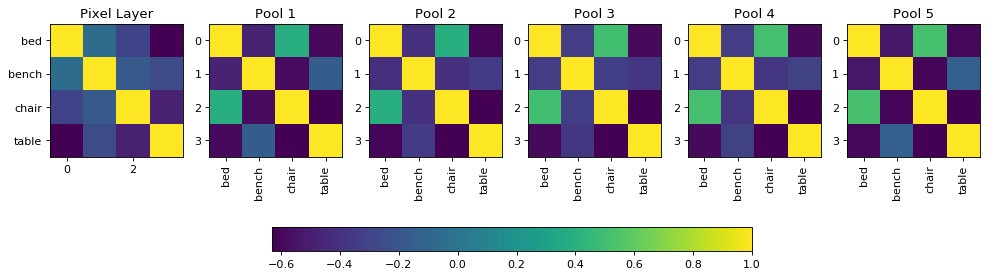

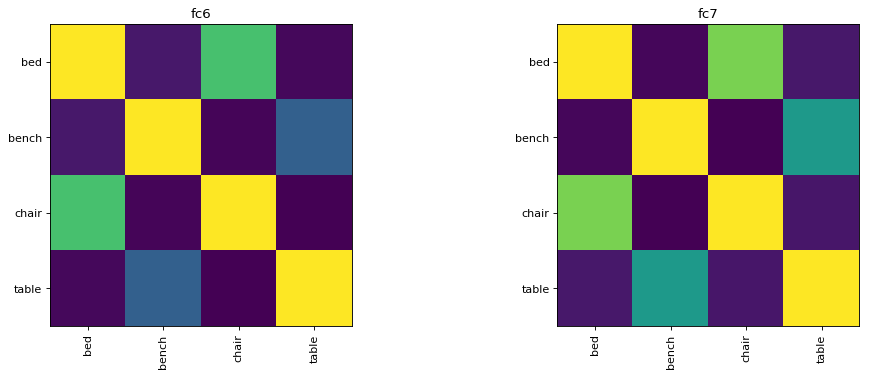

In [48]:
plot_all_RDM(RDM_M)

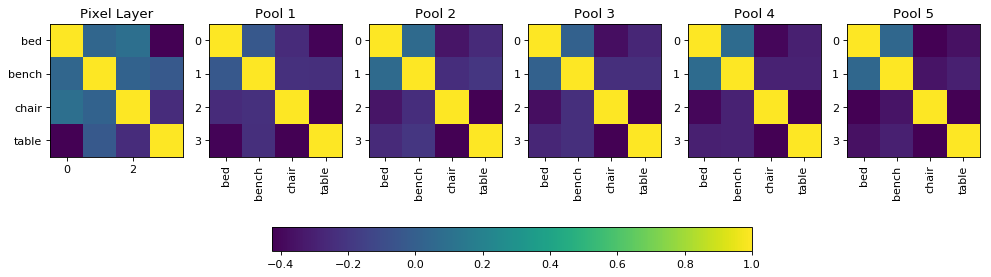

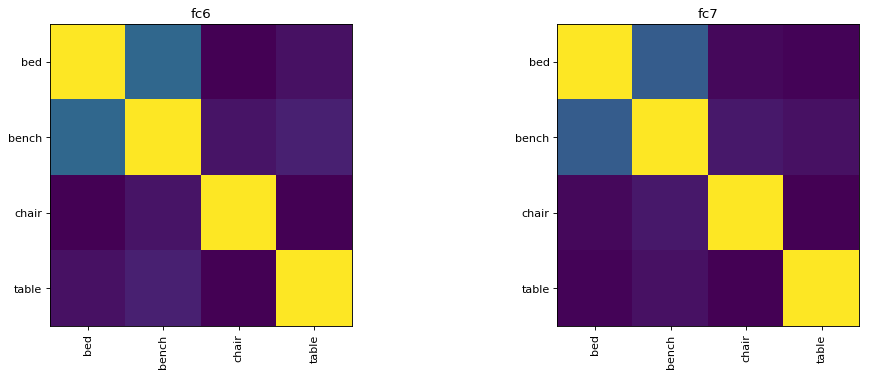

In [103]:
plot_all_RDM(RDM_M)

## RDM of the sketches

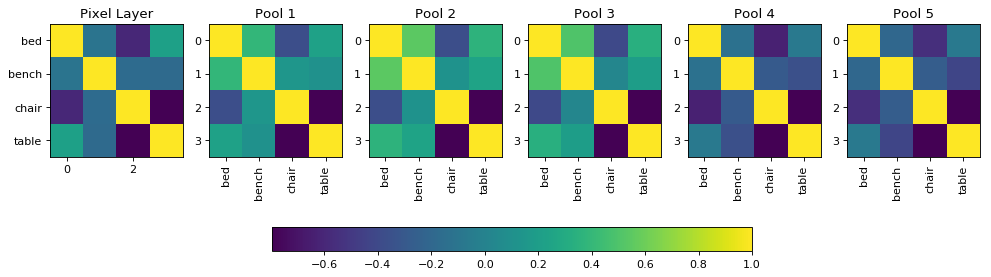

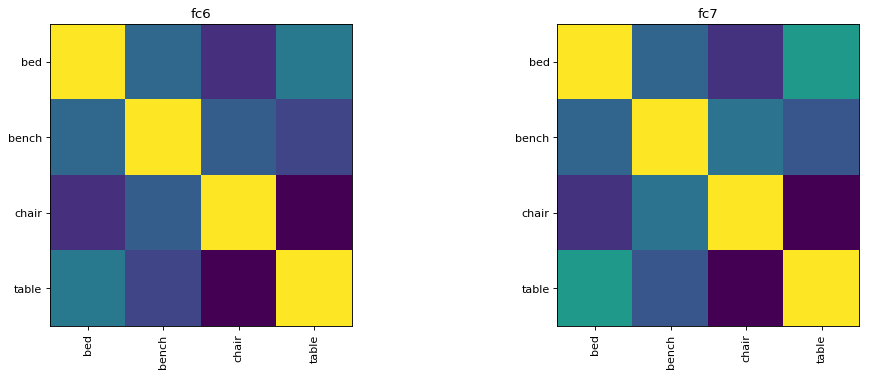

In [46]:


plot_all_RDM(RDM_S)

In [104]:

def get_off_diag(full):
    return full[np.triu_indices(4, 1)]
between_domains = []


for layer in xrange(0,8):
    between_domain_i = np.corrcoef(get_off_diag(RDM_S[layer]), get_off_diag(RDM_M[layer]))
    between_domains.append(between_domain_i[0, 1])
    print("pearson coefficient for between domains for layer " + str(layer) + " is " + str(between_domain_i[0, 1]))
    

pearson coefficient for between domains for layer 0 is -0.291950205646
pearson coefficient for between domains for layer 1 is 0.589542440654
pearson coefficient for between domains for layer 2 is 0.841781372413
pearson coefficient for between domains for layer 3 is 0.847429115821
pearson coefficient for between domains for layer 4 is 0.670559839523
pearson coefficient for between domains for layer 5 is 0.476223564675
pearson coefficient for between domains for layer 6 is 0.19302753811
pearson coefficient for between domains for layer 7 is 0.294977484055


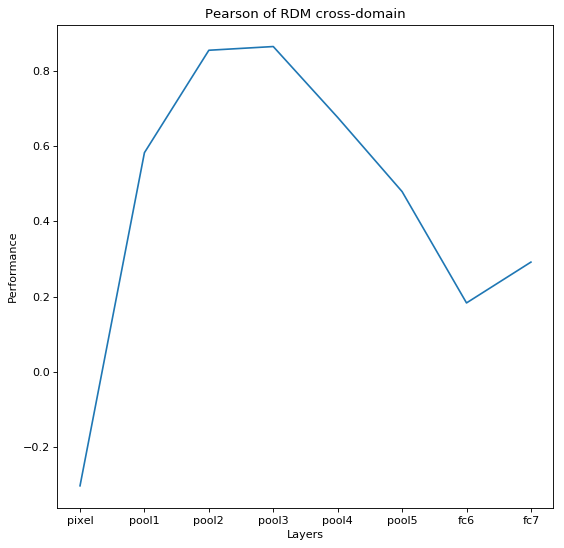

In [101]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("Pearson of RDM cross-domain")
plt.plot(xrange(8), between_domains)
plt.xlabel('Layers')
plt.ylabel('Performance')



plt.xticks(xrange(0,len(LAYERS) + 1), LAYERS_NM);


In [16]:
# seperate out the furniture data and the even views only 

    
    
_MP_furn = get_furn(_MP, even = True)
_ML_furn = get_furn(_ML, even = True)
_M_Path_f = get_furn(_M_Path, even = True)

_MF_furn = []
for layer in xrange(0,7):
    _MF_furn.append(get_furn(_MF[layer], even = True))
    
    
RDM_M_a = []
RDM_M_a.append(np.corrcoef(_MP_furn))
for layer in xrange(0,7):

    RDM_M_a.append(np.corrcoef(normalize(_MF_furn[layer])))

## RDM for 3D Models for each view

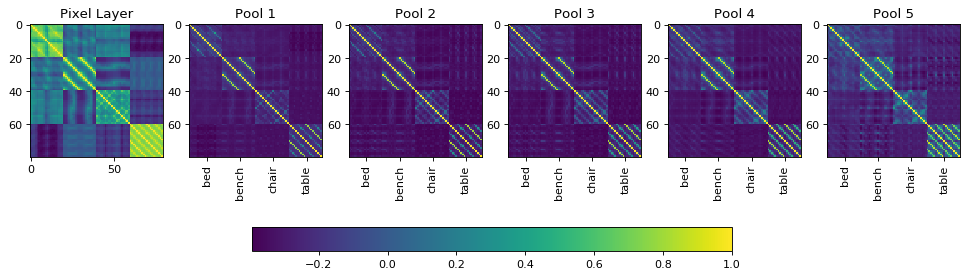

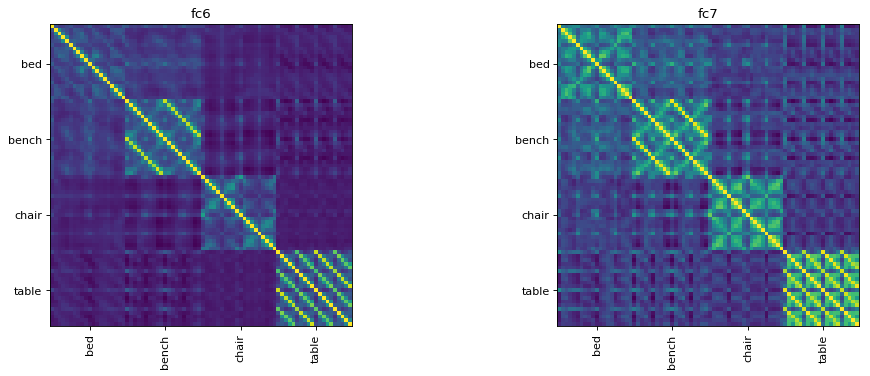

In [17]:
plot_all_RDM(RDM_M_a, full=True)

In [18]:
# plot RDM for all objects (no averaging) 
RDM_S_a = []

RDM_S_a.append(np.corrcoef(get_means_across_views(_SP, _SL, _SVP)))
for layer in xrange(0,7):
    
    RDM_S_a.append(np.corrcoef(get_means_across_views(_SF[layer], _SL, _SVP)))
    



## RDM for Sketches for each view

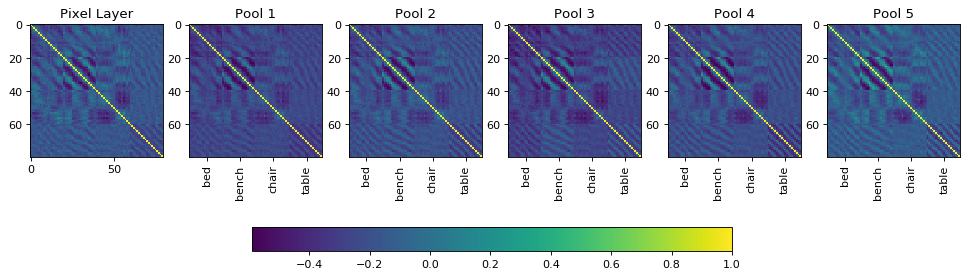

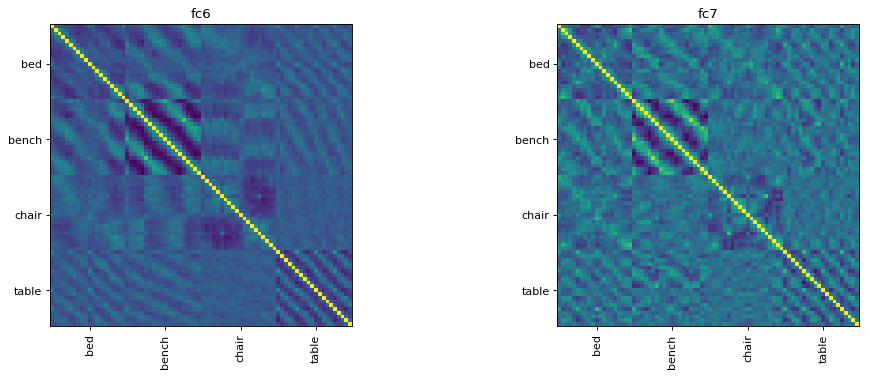

In [19]:
plot_all_RDM(RDM_S_a, full=True)

In [20]:

def get_off_diag(full):
    return full[np.triu_indices(4, 1)]
between_domains_all_views = []


for layer in xrange(0,8):
    between_domain_i = np.corrcoef(get_off_diag(RDM_S_a[layer]), get_off_diag(RDM_M_a[layer]))
    between_domains_all_views.append(between_domain_i[0, 1])
    print("pearson coefficient for between domains for layer " + str(layer) + " is " + str(between_domain_i[0, 1]))
    

pearson coefficient for between domains for layer 0 is 0.696204436108
pearson coefficient for between domains for layer 1 is 0.669803245925
pearson coefficient for between domains for layer 2 is 0.781642283785
pearson coefficient for between domains for layer 3 is 0.803866045575
pearson coefficient for between domains for layer 4 is 0.801226760865
pearson coefficient for between domains for layer 5 is 0.949771046474
pearson coefficient for between domains for layer 6 is 0.900730106755
pearson coefficient for between domains for layer 7 is 0.87504699745


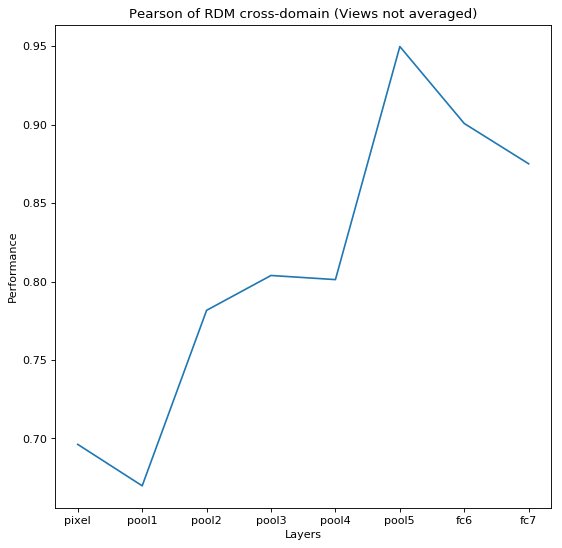

In [23]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("Pearson of RDM cross-domain (Views not averaged)")
plt.plot(xrange(8), between_domains_all_views)
plt.xlabel('Layers')
plt.ylabel('Performance')



plt.xticks(xrange(0,len(LAYERS) + 1), LAYERS_NM);
plt.savefig('cross_domain.pdf')


# Logistic Regression

In [101]:
layer_score.append(scores.mean)
print("Accuracy for pixel layer: %0.2f (+/- %0.2f)" % ( scores.mean(), scores.std() * 2))


Accuracy for pixel layer: 0.54 (+/- 0.08)


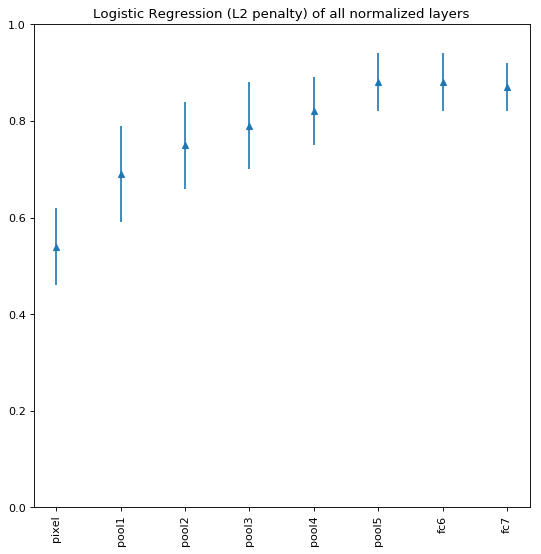

In [354]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

means = [0.54, 0.69, 0.75, 0.79, 0.82, 0.88, 0.88, 0.87]
stds = [0.08, 0.10, 0.09, 0.09, 0.07, 0.06, 0.06, 0.05]

plt.title('Logistic Regression (L2 penalty) of all normalized layers')
plt.errorbar(xrange(0, 8) , means, stds, linestyle='None', marker='^')
plt.ylim([0,1.0])


plt.xticks(xrange(0,8), LAYERS_NM, rotation='vertical');


In [110]:
print ('Running regression for sketches')
# layer scores for sketches 
layer_score_s = []
layer_std_s = []

# compute cross-validated softmax classifier accuracy 
# clf = svm.SVC(kernel='linear', C=1)ß

for i in reversed(xrange(0,7)):
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, _SF[i], _SL, cv=5)

    print("Accuracy for layer %f: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
    layer_score_s.append(scores.mean()) 
    layer_std_s.append(scores.std())


clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf, _SP, _SL, cv=5)
print("Accuracy for pixel layer: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
layer_score_s.append(scores.mean())
layer_std_s.append(scores.std())
layer_score_s = reversed(layer_score_s)
layer_std_s = reversed(layer_std_s)



Running regression for sketches
Accuracy for layer 6.000000: 0.89 (+/- 0.03)
Accuracy for layer 5.000000: 0.91 (+/- 0.03)
Accuracy for layer 4.000000: 0.89 (+/- 0.06)
Accuracy for layer 3.000000: 0.86 (+/- 0.04)
Accuracy for layer 2.000000: 0.78 (+/- 0.07)
Accuracy for layer 1.000000: 0.72 (+/- 0.05)
Accuracy for layer 0.000000: 0.66 (+/- 0.06)
Accuracy for pixel layer: 0.56 (+/- 0.06)


In [109]:
print ('Running regression for models')
# layer scores for models 
layer_score_m = []
layer_std_m = []

# compute cross-validated softmax classifier accuracy 
# clf = svm.SVC(kernel='linear', C=1)

for i in reversed(xrange(0,7)):
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, get_furn(_MF[i]), get_furn(_ML), cv=5)

    print("Accuracy for layer %f: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
    layer_score_m.append(scores.mean()) 
    layer_std_m.append(scores.std())


clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf, get_furn(_MP), get_furn(_ML), cv=5)
print("Accuracy for pixel layer: %0.2f (+/- %0.2f)" % ( scores.mean(), scores.std() * 2))
layer_score_m.append(scores.mean())
layer_std_m.append(scores.std())
layer_score_m = reversed(layer_score_m)
layer_std_m = reversed(layer_std_m)



Running regression for models
Accuracy for layer 6.000000: 0.97 (+/- 0.06)
Accuracy for layer 5.000000: 0.99 (+/- 0.03)
Accuracy for layer 4.000000: 0.99 (+/- 0.02)
Accuracy for layer 3.000000: 0.98 (+/- 0.08)
Accuracy for layer 2.000000: 1.00 (+/- 0.00)
Accuracy for layer 1.000000: 1.00 (+/- 0.00)
Accuracy for layer 0.000000: 0.99 (+/- 0.02)
Accuracy for pixel layer: 0.97 (+/- 0.10)


NameError: name 'scoers' is not defined

In [ ]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

# means = [0.54, 0.69, 0.75, 0.79, 0.82, 0.88, 0.88, 0.87]
# stds = [0.08, 0.10, 0.09, 0.09, 0.07, 0.06, 0.06, 0.05]

plt.title('Logistic Regression (L2 penalty) of all normalized layers')
plt.errorbar(xrange(0, 8) , layer_score_m, layer_stds_m, linestyle='None', marker='^')
plt.ylim([0,1.0])


plt.xticks(xrange(0,8), LAYERS_NM, rotation='vertical');


In [ ]:
# single train/test split

for i in reversed(xrange(0,7)):
    
    X_train, X_test, y_train, y_test = train_test_split(
        _SF[i], _SL, test_size=0.2, random_state=0)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    print("Score for single trial is %0.2f" % clf.score(X_test, y_test))

clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf, _SP, _SL, cv=5)
print("Score for single trial is %0.2f" % clf.score(X_test, y_test))

layer_score.append()
layer_score = reversed(layer_score)

Score for single trial is 0.85
Score for single trial is 0.90
Score for single trial is 0.91
Score for single trial is 0.89
Score for single trial is 0.81
Score for single trial is 0.77


# scrap

In [ ]:
plot_all_RDM(RDM_S_a)

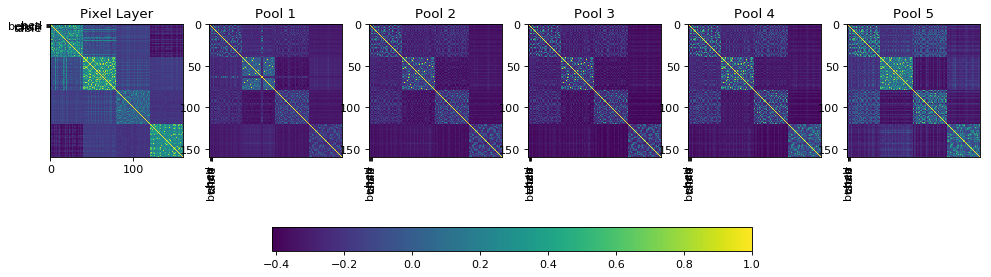

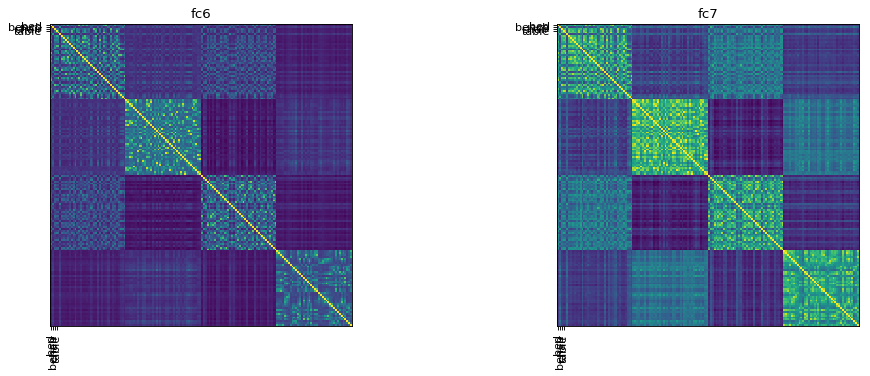

In [116]:
plot_all_RDM(RDM_D_a)

In [140]:
print _SL[63]
inds = np.argsort(DL)
sorted_paths = np.array(photo_paths)[inds]
sorted_paths[63]

bed


'/home/rslee/object_data/bench/tableBench_100_39.png.png'

In [26]:
raw_diff = []
for layer in xrange(0,8):
    raw_diff.append(np.mean(abs(RDM_S[layer] - RDM_D[layer])))

## comparing sketch features to model features

This isn't actualy the comparison we want. Features might be reprsented differently in later layers. It's not meaningful to look at how the features might be more similar in later layers

In [32]:
RDM_cross_full = [] # this will include all of the RDM info 
RDM_cross = []

cross = np.corrcoef(get_class_means(_SP, _SL), get_class_means(_MP_furn, _ML_furn))
RDM_cross_full.append(cross)
RDM_cross.append(cross[0:4, 4:8])

for layer in xrange(0,7):
    cross = np.corrcoef(get_class_means(_SF[layer], _SL), get_class_means(_MF_furn[layer], _ML_furn))
    RDM_cross_full.append(cross)
    RDM_cross.append(cross[0:4, 4:8])
    


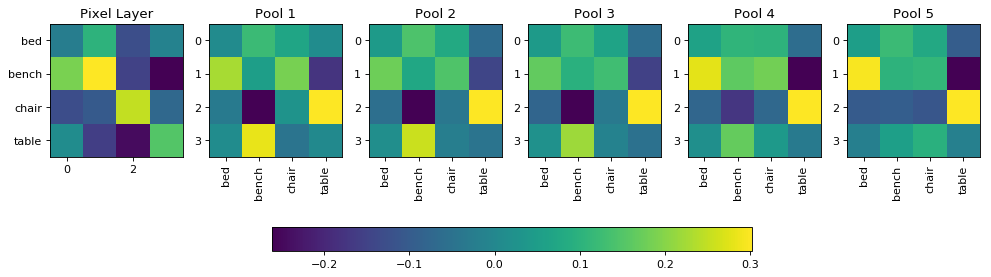

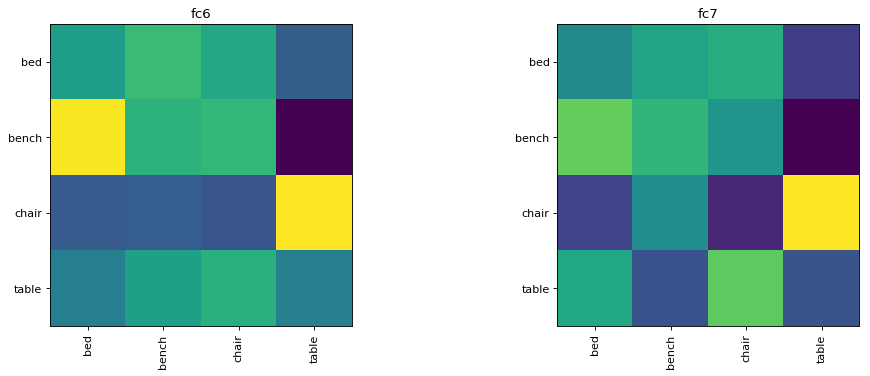

In [40]:
plot_all_RDM(RDM_cross)

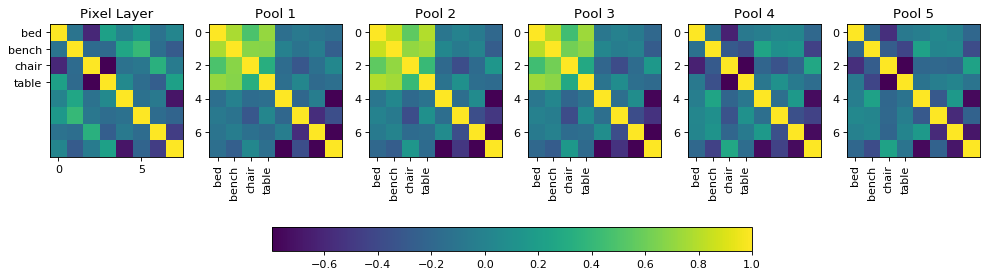

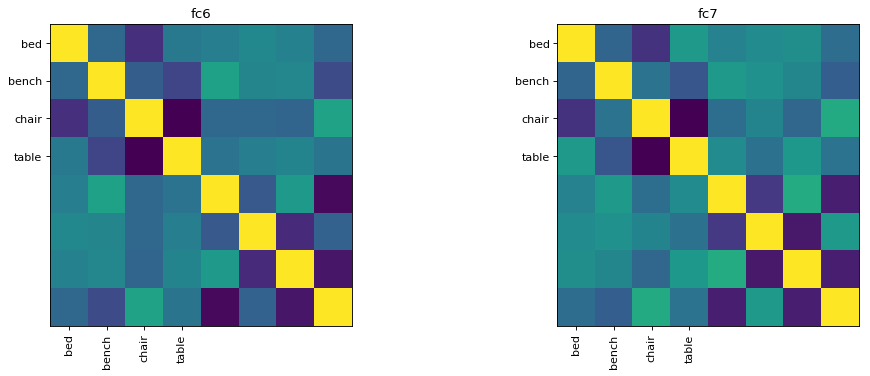

In [35]:
plot_all_RDM(RDM_cross_full)

In [59]:
between_domains = np.zeros((len(FURNITURES), len(LAYERS_NM)), float)


for layer in xrange(0,8):
    between_domains[:, layer] =  RDM_cross[layer].diagonal()
    print("pearson coefficient for between domains for layer " + str(layer) + " is " + str(between_domain_i))
    
    
print between_domains.shape
    

pearson coefficient for between domains for layer 0 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 1 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 2 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 3 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 4 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 5 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 6 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 7 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
(4, 8)


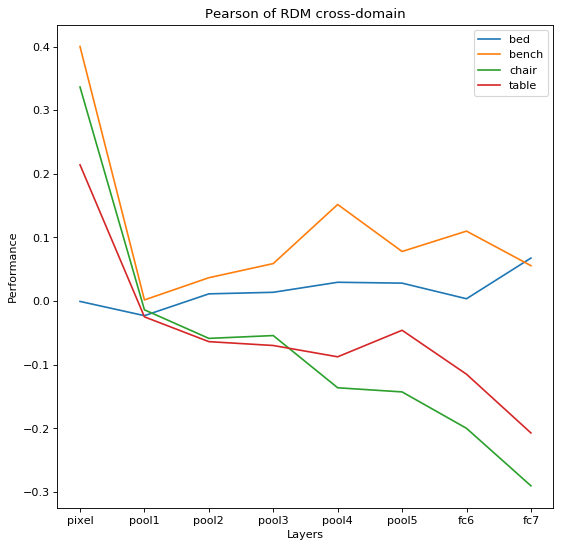

In [71]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("Pearson of RDM cross-domain")
lines = plt.plot(between_domains.transpose())
plt.xlabel('Layers')
plt.ylabel('Performance')

plt.legend(iter(lines), ('bed', 'bench', 'chair', 'table'))

plt.xticks(xrange(0,len(LAYERS) + 1), LAYERS_NM);
